In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

我们使用线性模型参数 w=[2,−3.4]⊤ 、 b=4.2  和噪声项 ϵ 生成数据集及其标签：

y=Xw+b+ϵ.

In [2]:

def synthetic_data(w,b,num_examples):
    #生成y=Xw+b+噪声
    # X 是一个均值为0方差为一的随机数，并且长度为w的列数
    X = torch.normal(0,1,(num_examples,len(w)))
    # X*w+b（偏差）
    y = torch.matmul(X,w)+b
    # +一个均值为0，标准差为0.1且形状与y相同的随机张量
    y += torch.normal(0,0.01,y.shape)
    # 将X和y作为列向量返回
    return X,y.reshape((-1,1))
true_w =torch.tensor([2,-3.4])
true_b = 4.2
features, labels = synthetic_data(true_w,true_b,1000)

In [3]:
print('features:',features[0],'\nlabel:',labels[0])

features: tensor([-0.5195,  2.1555]) 
label: tensor([-4.1670])


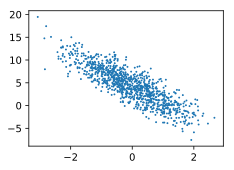

In [5]:
#通过生成第二个特征features[:, 1]和labels的散点图， 可以直观观察到两者之间的线性关系。
d2l.set_figsize()
# detach这里是分离的作用，使tensor转为numpy
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

### 读取数据集

In [6]:
def data_iter(batch_size,features,labels):
    num_examples = len(features)
    # 生成每个样本的index，将其转为list
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    # 每一次跳batch_size大小
    for i in range(0, num_examples,batch_size):
        batch_indices = torch.tensor(
        indices[i:min(i+batch_size,num_examples)]
        )
        # 产生随机顺序的特征和对应随机顺序的标号
        yield features[batch_indices],labels[batch_indices]

In [7]:
batch_size = 10
for X,y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.5960, -0.1337],
        [ 0.0827, -0.0064],
        [-0.0032, -2.0247],
        [-0.9164, -1.5359],
        [-0.7749,  0.4623],
        [-0.3534,  1.0273],
        [-1.4888,  1.3528],
        [ 0.1238, -1.1932],
        [ 0.3618, -0.6643],
        [-0.0392, -0.6613]]) 
 tensor([[ 5.8421e+00],
        [ 4.3808e+00],
        [ 1.1072e+01],
        [ 7.5844e+00],
        [ 1.0907e+00],
        [-8.2908e-03],
        [-3.3813e+00],
        [ 8.5039e+00],
        [ 7.1819e+00],
        [ 6.3749e+00]])


### 初始化模型参数
从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重， 并将偏置初始化为0。

In [9]:
w = torch.normal(0,0.01,size=(2,1),requires_grad = True)
b = torch.zeros(1,requires_grad=True)

In [11]:
# 定义线性模型
def linreg(X,w,b):
    return torch.matmul(X,w) + b

In [12]:
# 定义损失函数
# y_hat是预测值，y是真实值
# 这里将yreshape成y_hat的shape
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape))** 2/2

In [14]:
# 定义优化函数
# lr:学习率
def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= param - lr * param.grad / batch_size
            param.grad.zero_()

In [23]:
lr = 0.03
# 将整个数据集扫描三遍
num_epochs = 3
# 模型
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X,y in data_iter(batch_size,features,labels):
        l = loss(net(X,w,b),y)   #X和y的小批量损失
        # 计算L关于[w,b]的梯度
        l.sum().backward()
        sgd([w,b], lr, batch_size) #使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features,w,b),labels)
        print(f'epoch { epoch + 1}, loss {float(train_l.mean()):f}')
            

epoch 1, loss 19.154968
epoch 2, loss 18.128448
epoch 3, loss 19.061905
